# Case study : measuring, identifying and counting shapes

This case study will be carried out in Python3, using the [scikit-image](http://scikit-image.org/docs/stable/) library and or [opencv](https://docs.opencv.org/4.x/) library. The arrays (`ndarray`) used by these libraries to manipulate images come from the [numpy](https://docs.scipy.org/doc/) library. Images and other figures are displayed using [matplotlib](https://matplotlib.org/contents.html). The documentation for these four libraries will come in very handy.

In this case study, questions will be indicated in a **question** block, and answers will be given in the **answer** block below the question block or in a code block. Your answers should be written in [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). This will allow you to answer not only with text, but also with tables and images.

:::{important}
Since this is a case study, you will be much less guided that during the previous labs. Its is usually up to you to decide which method to use to solve the given questions. You should not only use code blocks, but you should also add markdown block in order to explain what you are doing and justify your choices
:::

*This project is based on an existing project proposed by prof. Harold Mouchère at Nantes Université IUT.*

The code cell below provides a few imports that are useful as a starting point. If you add additional dependencies don't forget to add them here so that we can reproduce your results easily.

In [1]:
%pip install -q scikit-image opencv-python ipywidgets matplotlib ipympl


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import cv2 
from skimage.filters import threshold_local
from skimage import io, util, filters, color, feature, transform, morphology, exposure, measure

```{figure} lego/lego_0.jpg
:alt: Lego 10
:height: 200px
:class: float-right
```

## Step 1 : (simple) lengths measurement

In the images of LEGO pieces `lego_0.jpg` to `lego_8.jpg`, the bars are 3 to 12 units long. All the images were taken with the same camera, at the same distance and with the same resolution. We're going to try to measure the length of the bars. For this first step, they all have the same orientation (horizontal) but are not all the same color.
1. Make a function that takes an image as parameter and returns the rectangle enclosing the bar. Draw the rectangle on the image.
    - Hint : first test on image `lego_1.jpg` it is easier to process than `lego_0.jpg`
3. Next, we'll calibrate our measurement. Knowing that the size of the bar in the image `lego_8.jpg` is 12, find the pixel value of one unit. 
4. Using the size of their bounding box, find the length of each bar (of images `lego_0.jpg` to `lego_8.jpg`) in units and pixels. Display the lengths in units and pixels. Is your algorithm working correctly on all images ? If not, try to improve it and explain the modifications made.


Measuring lego/lego_0.jpg
Bar size (pixels): 169
Bar size (units): 169.0


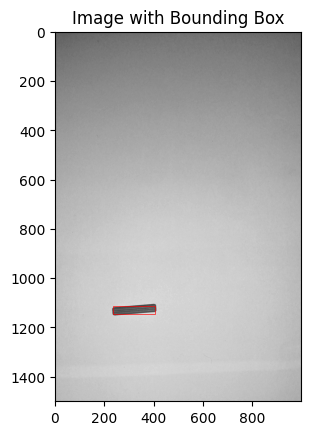

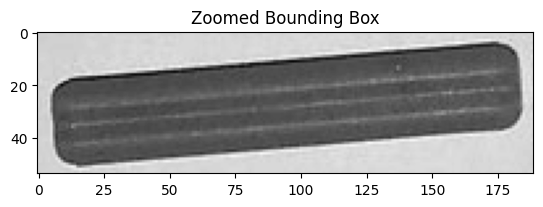


Measuring lego/lego_1.jpg
Bar size (pixels): 227
Bar size (units): 227.0


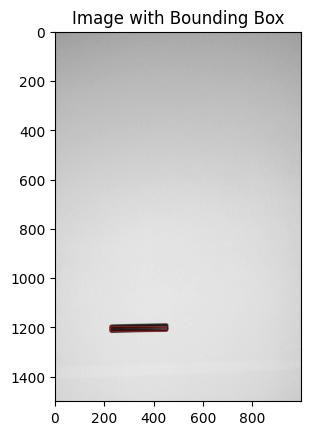

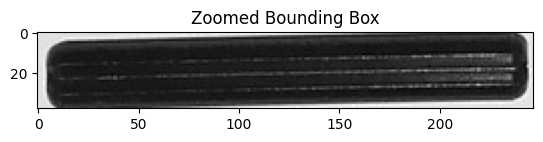


Measuring lego/lego_2.jpg
Bar size (pixels): 292
Bar size (units): 292.0


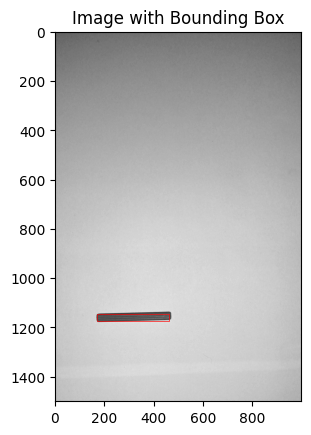

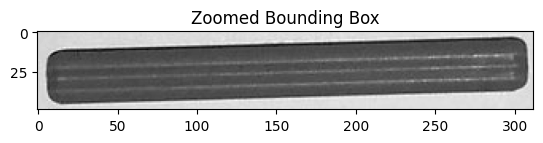


Measuring lego/lego_3.jpg
Bar size (pixels): 351
Bar size (units): 351.0


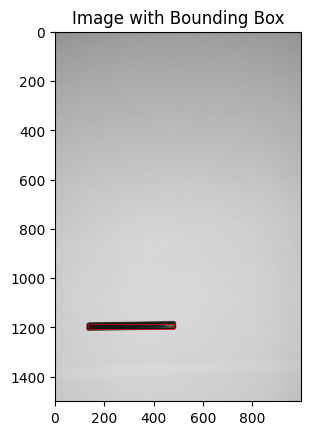

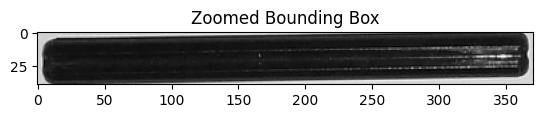


Measuring lego/lego_4.jpg
Bar size (pixels): 414
Bar size (units): 414.0


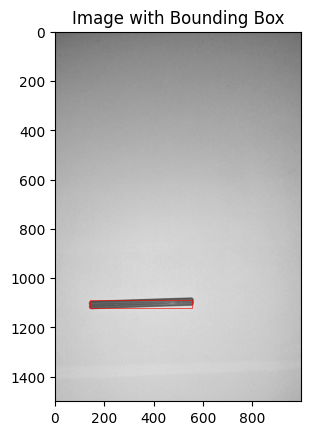

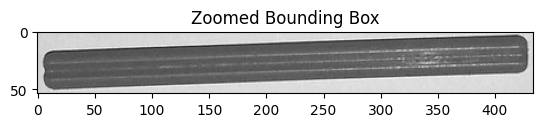


Measuring lego/lego_5.jpg
Bar size (pixels): 474
Bar size (units): 474.0


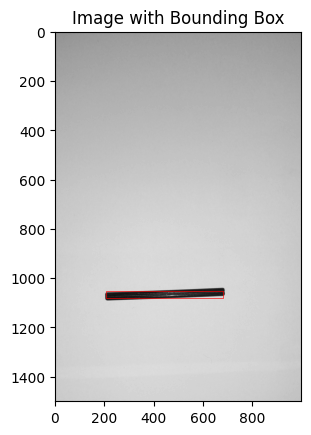

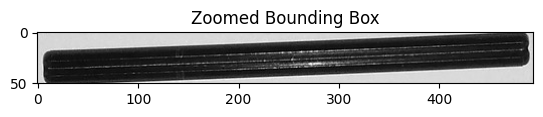


Measuring lego/lego_6.jpg
Bar size (pixels): 538
Bar size (units): 538.0


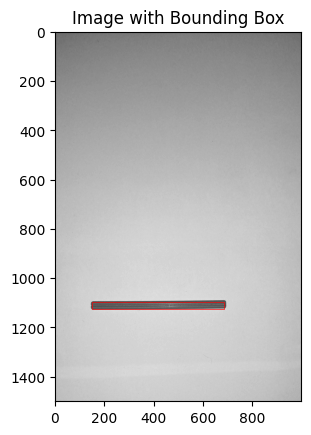

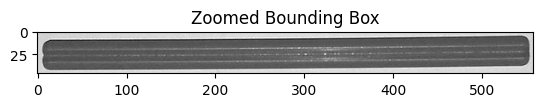


Measuring lego/lego_7.jpg
Bar size (pixels): 595
Bar size (units): 595.0


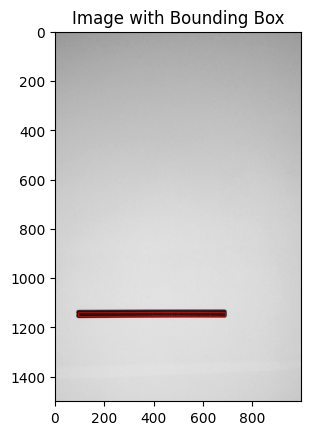

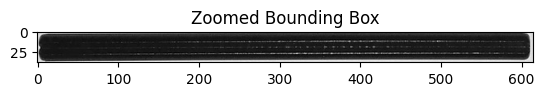


Measuring lego/lego_8.jpg
Bar size (pixels): 720
Bar size (units): 720.0


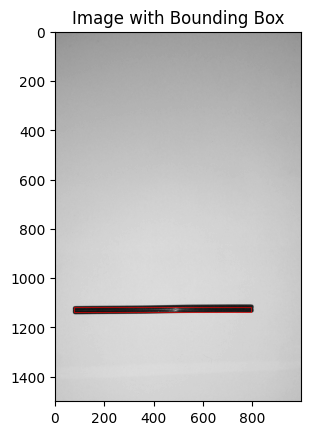

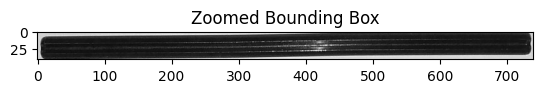

In [3]:
def measureBar(image):
    block_size = 35  # Size of the neighbourhood area
    adaptive_thresh = threshold_local(image, block_size, offset=10)
    binary_adaptive = image > adaptive_thresh

    # Find contours which should include the contour of the bar
    contours = measure.find_contours(binary_adaptive, 0.8)

    # Assuming the largest contour is the bar
    if contours:
        longest_contour = max(contours, key=lambda contour: measure.approximate_polygon(contour, tolerance=2.5).shape[0])

        # Find bounding box coordinates
        xmin = int(np.min(longest_contour[:, 1]))
        xmax = int(np.max(longest_contour[:, 1]))
        ymin = int(np.min(longest_contour[:, 0]))
        ymax = int(np.max(longest_contour[:, 0]))
    else:
        xmin = xmax = ymin = ymax = 0  # No contours found

    return xmin, xmax, ymin, ymax

# Process a single image as a test

for i in range(9):
    filename = f'lego/lego_{i}.jpg'
    print(f'\nMeasuring {filename}')
    image = io.imread(filename)
    image_gray = color.rgb2gray(image) * 255

    xmin, xmax, ymin, ymax = measureBar(image_gray)

    pixel_to_unit = 1  # Placeholder for actual pixel_to_unit ratio

    print('Bar size (pixels):', xmax-xmin)
    print('Bar size (units):', (xmax-xmin)/pixel_to_unit)

    # Show the image with bounding box in red
    plt.figure()
    plt.imshow(image_gray, cmap='gray')
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="red", alpha=0.9, fill=False, linewidth=0.5)
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title('Image with Bounding Box')
    plt.show()

    # Show only the bounding box area with a margin
    margin = 10  # Margin around the bounding box for the zoomed view
    plt.figure()
    plt.imshow(image_gray[max(ymin-margin, 0):min(ymax+margin, image_gray.shape[0]),
                        max(xmin-margin, 0):min(xmax+margin, image_gray.shape[1])], cmap='gray')
    plt.title('Zoomed Bounding Box')
    plt.show()


## Step 2 : measuring bars of any orientation

In this exercise, we'll look at another way of measuring bar lengths. We'll be looking at the length of the bar contour. In fact, the contour is equal to $2 * length + 2 * thickness$. 

First you'll design an algorithm based on the image `lego_1.jpg` , then you'll make a function that will return the size (in unit) of the bar passed in parameter. Finally, you'll test your solution on different images `lego_0.jpg` to `lego_8.jpg`. 

### 1. Algorithm design

Based on the various filters and segmentation methods seen in the different labs of this course, propose a series of processes to obtain a black image where the part's outline pixels are white. Like in the previous step, you will recover the bounding rectangle of these outline pixels to display just the part and its outline (with a small margin of 10 pixels) as shown below.


![](pieceEtContour.png)

Then simply count the white pixels with `np.sum(...)`, for example, for the image `lego_1.jpg` there are approximately 530 outline pixels.

In [4]:


# Load the image
image_path = 'lego/lego_1.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Adaptive thresholding
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a black background
contour_img = np.zeros_like(image)
cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 1)

# Find the bounding rectangles
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Expand bounding boxes by a margin and crop the region from the original image
margin = 10
cropped_images = []
for x, y, w, h in bounding_boxes:
    x_start, y_start = max(x - margin, 0), max(y - margin, 0)
    x_end, y_end = min(x + w + margin, image.shape[1]), min(y + h + margin, image.shape[0])
    cropped = image[y_start:y_end, x_start:x_end]
    cropped_images.append(cropped)

largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
x_start, y_start = max(x - margin, 0), max(y - margin, 0)
x_end, y_end = min(x + w + margin, image.shape[1]), min(y + h + margin, image.shape[0])

# Crop and save the image with the largest contour
cropped_image = image[y_start:y_end, x_start:x_end]
output_path = 'lego/cropped_lego_1.jpg'
cv2.imwrite(output_path, cropped_image)

output_path


'lego/cropped_lego_1.jpg'

### 2. Create a function

Take your algorithm and turn it into a function that displays the contour of the object found, returning the size (in unit) of the bar (like in step 1).

In [5]:

def find_object_contour_and_size(image_path):
    """
    This function takes an image path, finds the largest contour in the image, draws it,
    and returns the size of the bounding rectangle of this contour in pixels.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour is the object we want to find
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw contours on the original image
    contour_img = image.copy()
    cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 2)

    # Calculate the size of the bounding rectangle of the largest contour
    size = w, h
    
    return contour_img, size

# Path to the uploaded image
image_path = 'lego/lego_1.jpg'

# Use the function and get the result
contour_image, object_size = find_object_contour_and_size(image_path)
object_size_pixels = f"Width: {object_size[0]} pixels, Height: {object_size[1]} pixels"

# Save the image with the drawn contour
output_path_contour = 'lego/contour_lego_1.jpg'
cv2.imwrite(output_path_contour, contour_image)

output_path_contour, object_size_pixels


('lego/contour_lego_1.jpg', 'Width: 240 pixels, Height: 39 pixels')

### 3. Testing 

Test your algorithm on the 8 bar images `lego_1.jpg` to `lego_8.jpg`. Is your algorithm robust to all situations ? What are the limitations ? Can you improve it ? 
To go further, test your function on all the possible bars in images 9 to 11. To isolate the bars, you can use manual image cropping with pixel intervals (see below).

In [6]:

# Loop through images lego_2.jpg to lego_8.jpg
for i in range(2, 9):
    # Construct the image path
    image_path = f'lego/lego_{i}.jpg'

    # Use the function to get the contour and size
    contour_image, object_size = find_object_contour_and_size(image_path)
    object_size_pixels = f"Width: {object_size[0]} pixels, Height: {object_size[1]} pixels"

    # Save the image with the drawn contour
    output_path_contour = f'lego/contour_lego_{i}.jpg'
    cv2.imwrite(output_path_contour, contour_image)

    # Output the contour image path and object size
    print(output_path_contour, object_size_pixels)


lego/contour_lego_2.jpg Width: 303 pixels, Height: 43 pixels
lego/contour_lego_3.jpg Width: 364 pixels, Height: 40 pixels
lego/contour_lego_4.jpg Width: 425 pixels, Height: 48 pixels
lego/contour_lego_5.jpg Width: 485 pixels, Height: 52 pixels
lego/contour_lego_6.jpg Width: 548 pixels, Height: 39 pixels
lego/contour_lego_7.jpg Width: 609 pixels, Height: 35 pixels
lego/contour_lego_8.jpg Width: 732 pixels, Height: 41 pixels


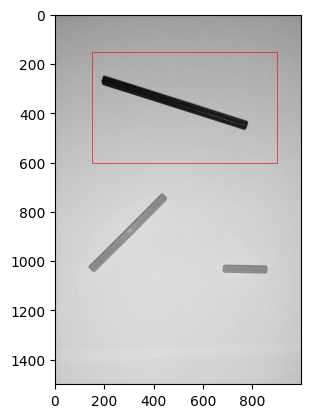

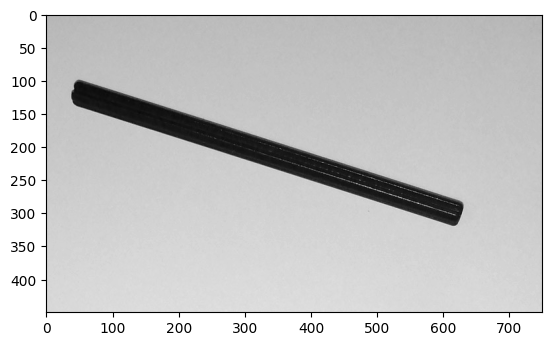

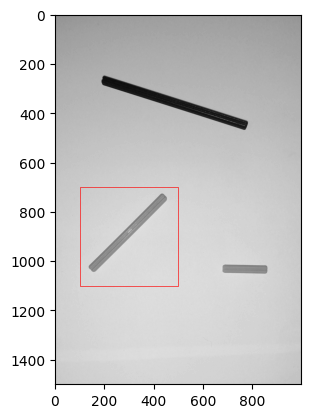

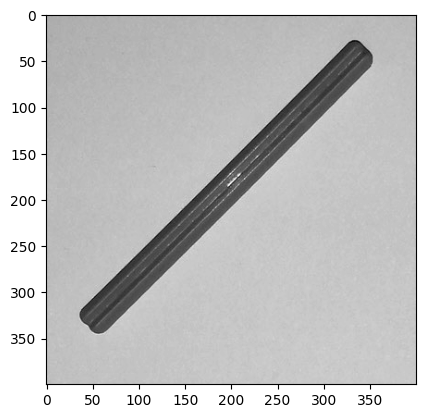

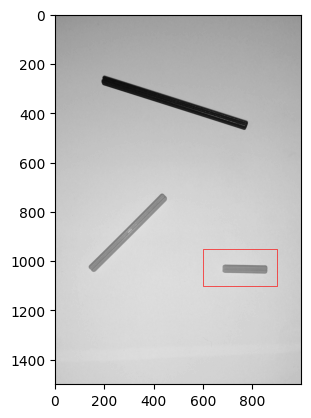

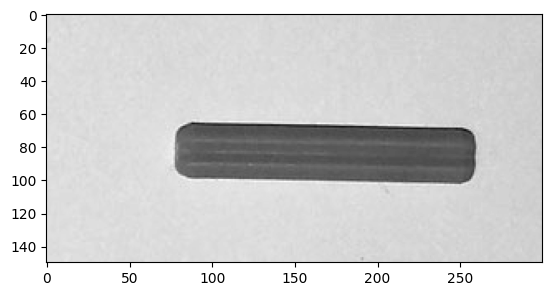

In [7]:
# Simple example showing how to crop the first bar of image 9
image=io.imread('lego/lego_9.jpg')
image = color.rgb2gray(image)
lego9_coords = [((150,900),(150,600)), ((100,500),(700,1100)), ((600,900),(950,1100))]
lego10_coords = [((200,500),(200,800)), ((500,900),(250,500)), ((0,550),(800,1450)), ((550,750),(600,1250))]
lego11_coords = [((0,450),(600,800)), ((500,750),(400,800)), ((300,750),(850,1200)), ((650,800),(1000,1300))]
# just for fun, display the fist bar of image 9
for l in range(len(lego9_coords)):
    bar_coords = lego9_coords[l]
    rect = plt.Rectangle((bar_coords[0][0], bar_coords[1][0]), bar_coords[0][1]-bar_coords[0][0], bar_coords[1][1]-bar_coords[1][0],
                     edgecolor="red", alpha=0.9, fill=False, linewidth=0.5)
    ax = plt.gca()
    ax.add_patch(rect)
    # then crop it
    img_B1 = image[bar_coords[1][0]:bar_coords[1][1],bar_coords[0][0]:bar_coords[0][1]]
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.imshow(img_B1, cmap='gray')
    plt.show()

In [8]:

# Loop through images lego_2.jpg to lego_8.jpg
for i in range(9, 12):
    # Construct the image path
    image_path = f'lego/lego_{i}.jpg'

    # Use the function to get the contour and size
    contour_image, object_size = find_object_contour_and_size(image_path)
    object_size_pixels = f"Width: {object_size[0]} pixels, Height: {object_size[1]} pixels"

    # Save the image with the drawn contour
    output_path_contour = f'lego/contour_lego_{i}.jpg'
    cv2.imwrite(output_path_contour, contour_image)

    # Output the contour image path and object size
    print(output_path_contour, object_size_pixels)


lego/contour_lego_9.jpg Width: 593 pixels, Height: 221 pixels
lego/contour_lego_10.jpg Width: 461 pixels, Height: 599 pixels
lego/contour_lego_11.jpg Width: 364 pixels, Height: 257 pixels


## Step 3: counting objects

In this part, we'll look at how to use morphological operations to count objects in an image. 

```{figure} lego/lego_10.jpg
:alt: Lego 10
:height: 200px
:class: float-right
```
### 1. Black and gray bars

First, design an algorithm based on image `lego_9.jpg`, then test it on images `lego_10.jpg` and `lego_11.jpg`. Convert the images to grayscale for easier processing. Then binarize the images to keep only the pixels belonging to the lego bars. Use morphological operations to remove isolated pixels, then count the remaining objects by counting the number of connected components. You can filter connected components by size to keep only the lego bars.

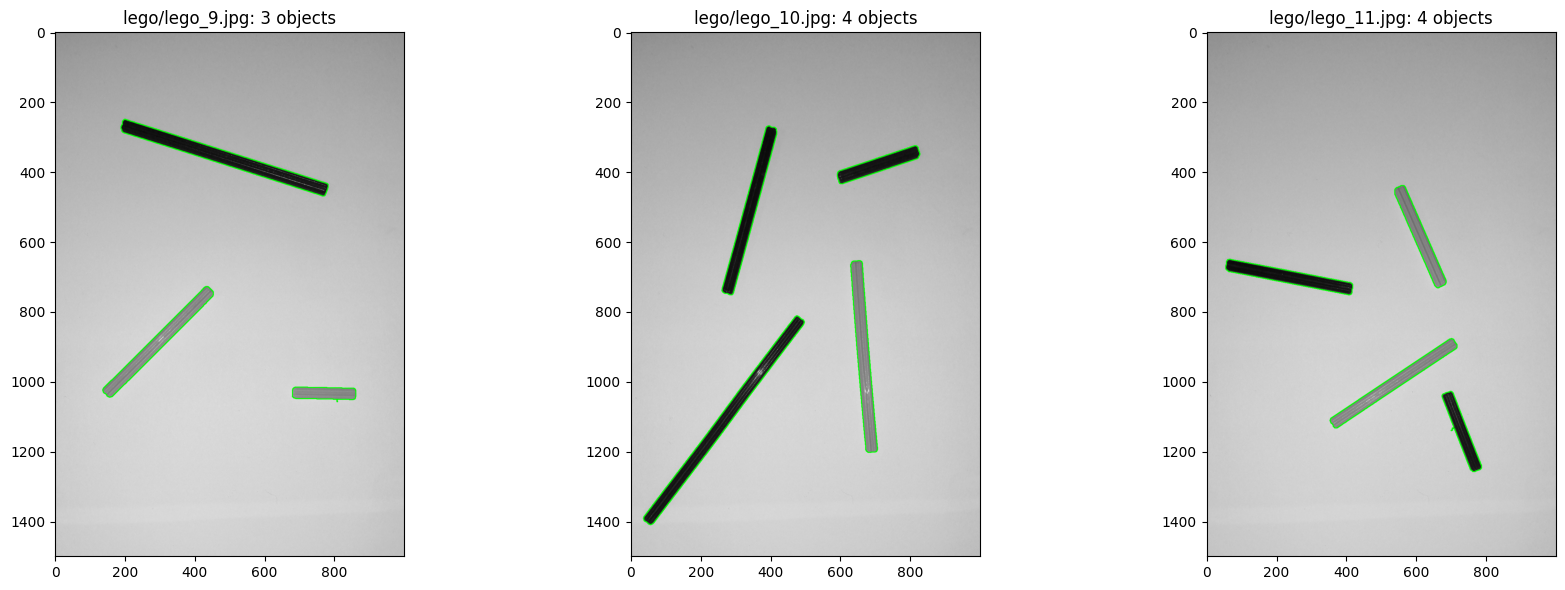

In [9]:
def process_and_count_objects_opencv(image_path):
    # Load the image in grayscale, check if the image is loaded correctly
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return 0, None

    # Apply a blur to smooth the image to reduce noise and improve thresholding
    blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Use adaptive thresholding to accommodate different lighting conditions across the images
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Use morphological operations to close small gaps and remove noise
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours of the objects
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area to remove small noise
    lego_bar_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 200]

    # Count the filtered contours which should correspond to the lego bars
    num_objects = len(lego_bar_contours)

    # Create an output image to draw the contours for visualization
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_image, lego_bar_contours, -1, (0, 255, 0), 2)

    return num_objects, output_image

# process the three images 
count_lego_9_cv, processed_lego_9_cv = process_and_count_objects_opencv('lego/lego_9.jpg')
count_lego_10_cv, processed_lego_10_cv = process_and_count_objects_opencv('lego/lego_10.jpg')
count_lego_11_cv, processed_lego_11_cv = process_and_count_objects_opencv('lego/lego_11.jpg')

# Results for the first image
count_lego_9_cv, processed_lego_9_cv if processed_lego_9_cv is not None else "Image not loaded correctly"

# Results for the second image
count_lego_10_cv, processed_lego_10_cv if processed_lego_10_cv is not None else "Image not loaded correctly"

# Results for the third image
count_lego_11_cv, processed_lego_11_cv if processed_lego_11_cv is not None else "Image not loaded correctly"

# Display the processed images with the detected Lego bars outlined
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Processed image for lego_9.jpg
axes[0].imshow(cv2.cvtColor(processed_lego_9_cv , cv2.COLOR_BGR2RGB))
axes[0].set_title(f'lego/lego_9.jpg: {count_lego_9_cv} objects')

# Processed image for lego_10.jpg
axes[1].imshow(cv2.cvtColor(processed_lego_10_cv , cv2.COLOR_BGR2RGB))
axes[1].set_title(f'lego/lego_10.jpg: {count_lego_10_cv} objects')

# Processed image for lego_11.jpg
axes[2].imshow(cv2.cvtColor(processed_lego_11_cv , cv2.COLOR_BGR2RGB))
axes[2].set_title(f'lego/lego_11.jpg: {count_lego_11_cv} objects')

plt.tight_layout()
plt.show()


```{figure} lego/lego_12.jpg
:alt: Lego 12
:height: 200px
:class: float-right
```
### 2. Color shapes

Use the same kind of algorithm for the images `lego_12.jpg` to `lego_15.jpg`. You'll start by focusing on the red and yellow parts in images `lego_12.jpg` and `lego_13.jpg`. Then you'll look at the objects in images `lego_14.jpg` and `lego_15.jpg`. Is it possible to count the pieces of each color?

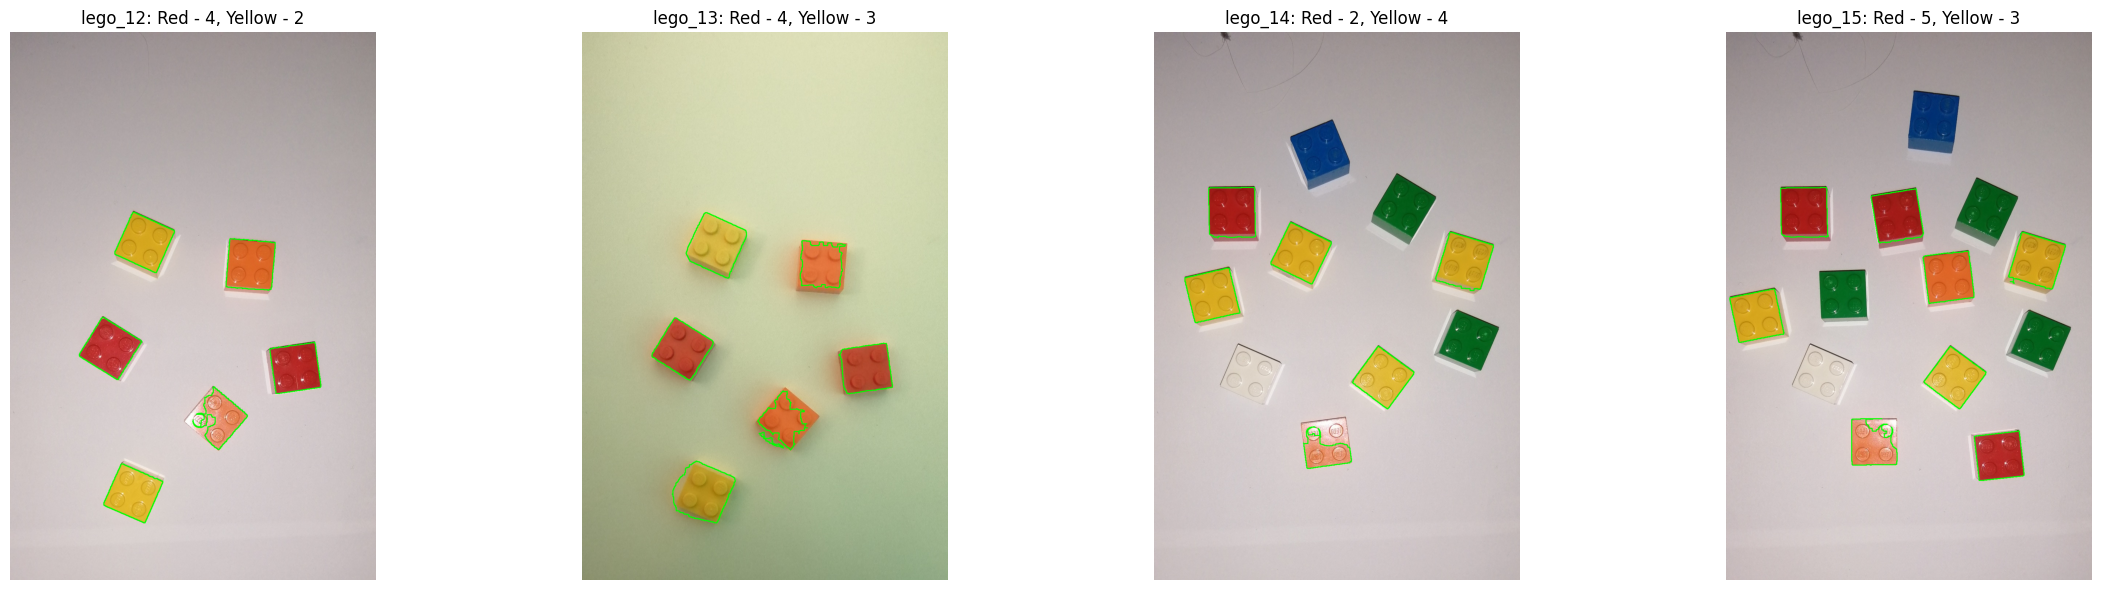

{'lego_12': {'red': 4, 'yellow': 2},
 'lego_13': {'red': 4, 'yellow': 3},
 'lego_14': {'red': 2, 'yellow': 4},
 'lego_15': {'red': 5, 'yellow': 3}}

In [13]:
# Define a function to process the images and count the red and yellow Lego pieces
def count_colored_pieces(image_path, colors_to_count):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return {color: 0 for color in colors_to_count}, None  # Return 0 count if the image can't be loaded

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define counters for each color
    color_counters = {color: 0 for color in colors_to_count}

    # Define HSV color ranges for red and yellow
    color_ranges = {
        'red': [([0, 100, 100], [10, 255, 255]), ([160, 100, 100], [179, 255, 255])],  # Red has two ranges
        'yellow': [([20, 100, 100], [30, 255, 255])]
    }

    # Create an output image to draw the contours for visualization
    output_image = image.copy()

    for color in colors_to_count:
        # Initialize a mask for the color ranges
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)

        # Go through each range and add it to the mask
        for color_range in color_ranges[color]:
            lower_bound = np.array(color_range[0], dtype=np.uint8)
            upper_bound = np.array(color_range[1], dtype=np.uint8)
            mask += cv2.inRange(hsv_image, lower_bound, upper_bound)

        # Use morphological operations to close small gaps and remove noise
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Find contours of the objects
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours by area to remove small noise and count them
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 200]
        color_counters[color] = len(filtered_contours)

        # Draw contours on the output image
        cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 2)

    return color_counters, output_image

# Paths to the new lego images
lego_images_paths = {
    'lego_12': 'lego/lego_12.jpg',
    'lego_13': 'lego/lego_13.jpg',
    'lego_14': 'lego/lego_14.jpg',
    'lego_15': 'lego/lego_15.jpg'
}




# Define the function as provided in your snippet (code omitted for brevity)

# Paths to the new lego images
lego_images_paths = {
    'lego_12': 'lego/lego_12.jpg',
    'lego_13': 'lego/lego_13.jpg',
    'lego_14': 'lego/lego_14.jpg',
    'lego_15': 'lego/lego_15.jpg'
}

# Focus on red and yellow parts for all four images
red_yellow_counts = {}
processed_images = {}
for image_name, image_path in lego_images_paths.items():
    red_yellow_counts[image_name], processed_images[image_name] = count_colored_pieces(image_path, ['red', 'yellow'])

# Display the processed images with the counts for red and yellow parts
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Adjust the subplot to include four images
for idx, (image_name, image) in enumerate(processed_images.items()):
    if image is not None:
        axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"{image_name}: Red - {red_yellow_counts[image_name]['red']}, Yellow - {red_yellow_counts[image_name]['yellow']}")
        axes[idx].axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

# Output the red and yellow counts for all images
red_yellow_counts


```{figure} lego/lego_16.jpg
:alt: Lego 16
:height: 200px
:class: float-right
```
### 3. Circles and squares

In the images `lego_16.jpg` to `lego_18.jpg` you'll count the circular and square pieces. First, you'll propose an algorithm for cutting the pieces, whatever their color and shape. Then you'll need to distinguish between round and square pieces so you can count them. You can use different kinds of shape descriptors for that.

In [16]:
def count_shapes_refined(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, "Image not loaded correctly"

    # Binarize the image using Otsu's thresholding
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Counters for shapes
    square_count = 0
    circle_count = 0

    # Loop through the contours and analyze the shape
    for cnt in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(cnt)

        # Filter out small areas which might be noise
        if area > 100:  # Area threshold, 
            # Approximate the contour to reduce the number of points
            perimeter = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * perimeter, True)

            # Calculate the bounding rectangle to get the aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Calculate circularity
            circularity = (4 * np.pi * area) / (perimeter * perimeter)

            # Check if square based on aspect ratio close to 1 and number of vertices
            if 0.8 < aspect_ratio < 1.2 and len(approx) == 4:
                square_count += 1
            elif circularity > 0.7:  # Adjust the circularity threshold as needed
                circle_count += 1

    return {'square': square_count, 'circle': circle_count}


# Apply the algorithm to the images 'lego_16.jpg', 'lego_17.jpg', and 'lego_18.jpg'
counts_lego_16 = count_shapes_refined('lego/lego_16.jpg')
counts_lego_17 = count_shapes_refined('lego/lego_17.jpg')
counts_lego_18 = count_shapes_refined('lego/lego_18.jpg')

counts_lego_16, counts_lego_17, counts_lego_18



({'square': 2, 'circle': 0},
 {'square': 3, 'circle': 2},
 {'square': 2, 'circle': 2})